In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
%matplotlib inline

In [2]:
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel("wave number [1/cm]")
    plt.ylabel("Intensity")

## Import degli spettri puri e degli spettri di sampling

In [3]:
#definisco i nomi da assegnare ai punti delli spettri di sampling
#wn -> wave number  r -> row c -> columns
names = ['wn']+[f'r{k}c{i}' for k in range(1,12) for i in range(1,12)]

### Importo solo il primo dei due campioni (spettri di sampling)

In [4]:
#quì importiamo i dati dei sampling in dataframes pandas, la colonna dei numeri d'onda è una unica per tutti
data = pd.read_csv('../data/raw/S1_mapA_11x11.txt', delim_whitespace=True, names=names)
data_bkg = pd.read_csv('../data/raw/S1_bkg_mapA_11x11.txt', delim_whitespace=True, names=names)

### Import degli spettri puri
Sceglaimo di inserire tutti gli spettri puri in una struttura dataframe di Pandas, sebbene questi abbianno lunghezze divere.

In [5]:
# gli spettri Raman dei materiali puri hanno ognuno uno wn diverso, generiamo dunque un dataframe vuoto delle
# dimensioni corrette (del materiale con più dati), e poi aggiungiamo 2 colonne per spettro con wn e l'intensità (probabilmente c'è un 
# metodo migliore)

# definisco i nomi dei vari materiali usando il file che li contiene tutti
pure_material_names=[]
with open('../data/raw/Database Raman/BANK_LIST.dat') as f:
    pure_material_names=[i[1:len(i)-5] for i in f.readlines()]
l=[]
# calcolo la dimensione del materiale puro con più dati
for i in range(len(pure_material_names)):
    l.append(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wl',pure_material_names[i]+'_I']).size)
max_size=int(max(l)/2)

In [6]:
# genero un dataframe vuoto per poter usare il metodo join
pure_materials = pd.DataFrame(np.zeros(max_size),columns=['empty'])
# importiamo i dati: nome_I (intensità) e nome_wn
for i in range(len(pure_material_names)):
    pure_materials=pure_materials.join(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wn',pure_material_names[i]+'_I']))
    
pure_materials.drop('empty', axis = 1,inplace=True)

pure_materials 
# occhio che hanno lunghezze diverse, se faccio qualcosa sui dati devo tenere conto che alcune righe sono NaN! 

,Albite_wn,Albite_I,Almandine_wn,Almandine_I,Amesite_wn,Amesite_I,Anatase_wn,Anatase_I,Andradite_wn,Andradite_I,...,Talc_wn,Talc_I,Titanite_wn,Titanite_I,Tremolite_wn,Tremolite_I,Zircon_wn,Zircon_I,Zoisite_wn,Zoisite_I
0,100.0000,0.00000,100.0000,0.000000,100.0000,0.000000,100.0000,0.00000,100.0000,0.000000,...,100.0000,0.000000,100.0000,0.0000,100.0000,0.000000,100.0000,0.000000,100.0000,0.000000
1,130.3772,0.00000,127.8412,0.000000,108.7196,0.000000,119.7566,0.00000,122.4867,0.000000,...,153.7797,0.000000,150.2341,0.0000,141.9265,0.000000,155.9293,0.000000,163.1987,0.000000
2,130.8593,29.94379,128.3233,0.388184,109.2017,6.031250,120.2387,228.53710,122.9688,8.033752,...,154.2619,0.392578,150.7162,167.7500,142.4086,4.830078,156.4115,24.014160,163.6808,18.185550
3,131.3414,40.09552,128.8054,0.040894,109.6838,1.233398,120.7209,27.95508,123.4509,7.316895,...,154.7440,9.555908,151.1983,283.5840,142.8907,0.161621,156.8936,35.441410,164.1630,26.076170
4,131.8235,32.20599,129.2875,14.570310,110.1660,6.476074,121.2030,84.98828,123.9330,2.533508,...,155.2261,41.726320,151.6805,256.0781,143.3728,6.734375,157.3757,5.512695,164.6451,3.950195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Spettri puri

Andiamo prima di tutto a vedere come sono fatti gli spettri dei materiali puri che, come capiamo subito, sono molto meno rumorosi rispetto agli spettri del nostro campine. Notiamo inoltre, guardando i dataframes, che le lunghezze d'onda a cui sono campionati gli spettri di materiale puro sono diverse tra materiali diversi. Nel compararli con i nostri campioni sarà sicuramente necessaria dunque un'interpolazione lineare.

Di seguito plottiamo come esempio lo **spettro puro dell'Albite**. Notiamo come lo spettro è poco rumoroso e non presenti offset significativi: lontano dalle frequenze di assorbimento degli stati rotazionali/vibrazionali delle molecole lo spettro va a zero, dunque non è assorbita alcuna radiazione.

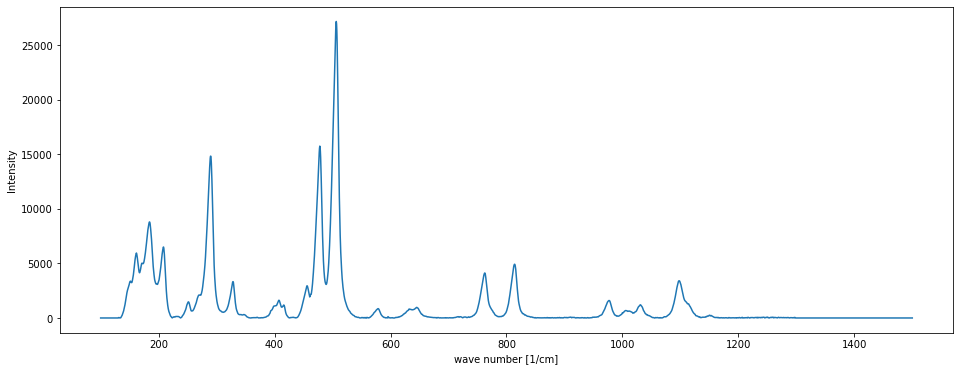

In [7]:
raman_plot()
plt.plot(pure_materials.Albite_wn,pure_materials.Albite_I)

Vogliamo ora comparare diversi spettri puri per imparare il più possibile l'andamento delle curve Raman. Per fare ciò notiamo però che questi spettri non sono normalizzati tra di loro. Dato che l'area sotto lo spettro corrisponde sperimentalmente al tempo di esposizione della misura (fonte: pdf di introduzione), e questa non è una quantità a cui siamo interessati, scegliamo di normalizzare (ad area unitaria) tutti gli spettri.

### Normalizzazione degli spettri puri

In [8]:
# qui abbiamo usato dropna per risolvere il problema che alcuni spettri hanno un numero diverso di dati.
# la normalizzazione è fatta utilizzando l'integrazione discreta con trapezi (np.trapaz)
for i in pure_material_names:
    pure_materials[i+'_I']=pure_materials[i+'_I']/np.trapz(abs(pure_materials[i+'_I'].dropna()), x=pure_materials[i+'_wn'].dropna())

Plottiamo dunque di seguito **tutti gli spettri puri normalizzati**.

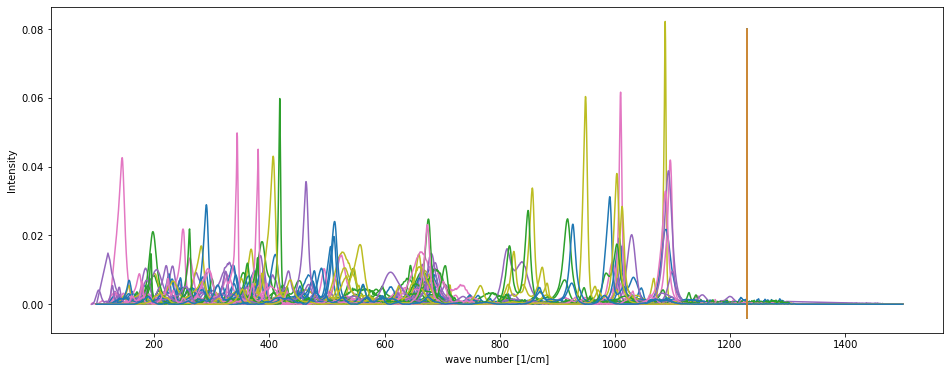

In [9]:
raman_plot()
for i in range(len(pure_material_names)):
    plt.plot(pure_materials[pure_material_names[i]+'_wn'],pure_materials[pure_material_names[i]+'_I'])
    plt.plot([1230,1230],[-0.004,0.08])

Notiamo che nessuno degli spettri puri presenta un rumore rilevante, assumiamo dunque che questi spettri rappresentino gli spettri Raman corretti per i materiali nella lista. Assumiamo inoltre che i materiali puri dati coprano quelli di cui sono composti i nostri campioni incogniti (anche se questo non fosse vero è sufficente che coprano i materiali principali). Dunque possiamo ottenere numerose informazioni da questi spettri:
1. **Per numeri d'onda superiori a 1230 $cm^{-1}$ (linea arancione verticale) tutti gli spettri Raman non presentano picchi rilevanti, l'intensità a piccole lunghezze d'onda è nulla!**
2. **Gli spettri Raman, relativamente alle altezze dei picchi, non presentano un offset rilevante. Nella coda del grafico tutti gli spettri Raman vanno a zero.**
3. **Le FWHM dei picchi sono, certe volte, importanti: fino a 100 $cm^{-1}$.**
4. **Lo spettro fino a circa 1230 $cm^{-1}$ è densamente popolato.**

Tratteremo i dati relativi agli spettri incogniti utilizzando queste informazioni.

## Spettri incogniti

### Con cosa stiamo lavorando?

Vediamo come sono gli **spettri sperimentali con rumore di background**, di seguito plottiamo i primi trè.

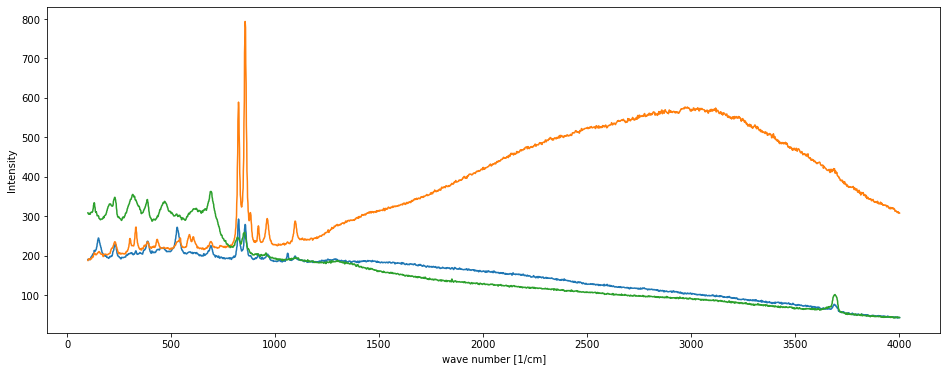

In [10]:
raman_plot()
plt.plot(data.wn,data.r1c1)
plt.plot(data.wn,data.r1c2)
plt.plot(data.wn,data.r1c3);

E qui li plottiamo tutti. Capiamo che i tempi di esposizione per punti diversi del campione di materiale sono sensibilmente diversi, come lo è anche la forma del background.

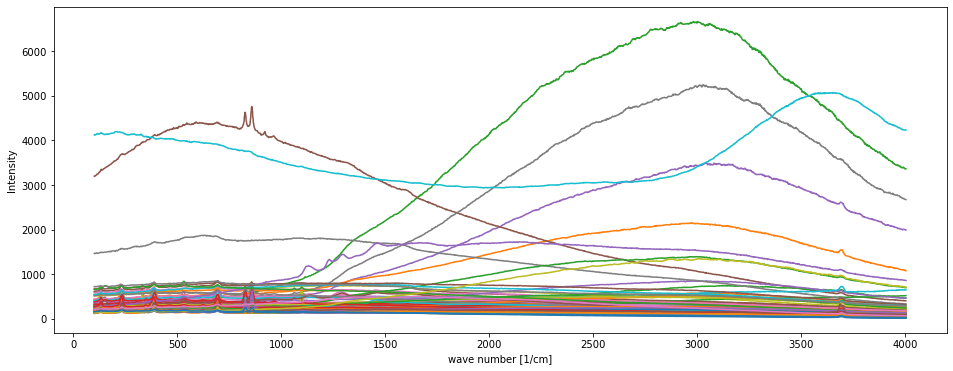

In [11]:
raman_plot()
for temp in names[1:]:
    plt.plot(data.wn,data[temp])

Andiamo a vedere come sono gli **spettri sincogniti con il background rimosso**, di seguito come prima i primi tre punti.

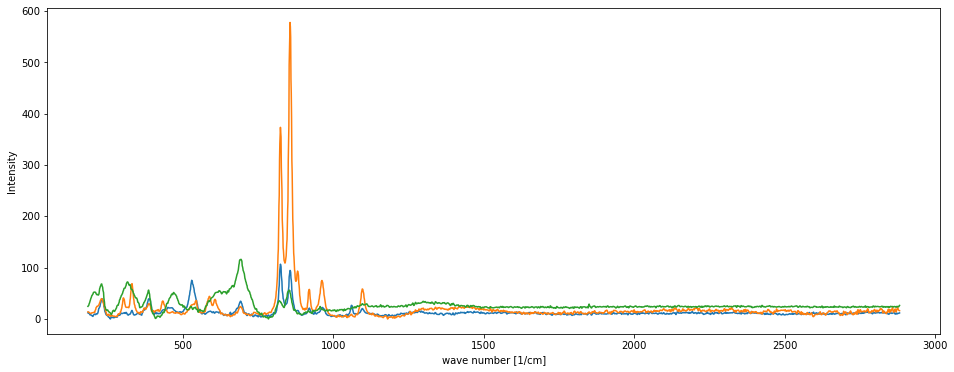

In [12]:
raman_plot()
plt.plot(data_bkg.wn,data_bkg.r1c1)
plt.plot(data_bkg.wn,data_bkg.r1c2)
plt.plot(data_bkg.wn,data_bkg.r1c3);

E poi tutti.

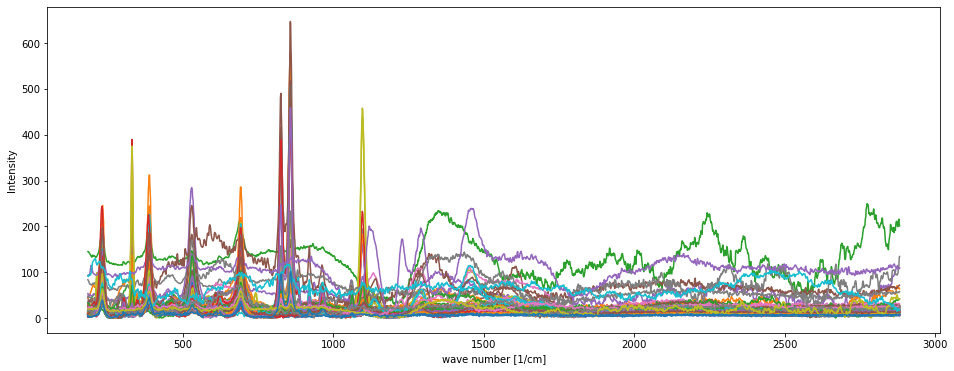

In [13]:
raman_plot()
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp]);

Andiamo anche a vedere quale è la **differenza tra uno spettro con rumore di background e uno senza**. Non ci sembra che il background possa darci informazioni utili e dunque, da qui in poi, tratteremo solo gli spettri a background rimosso.

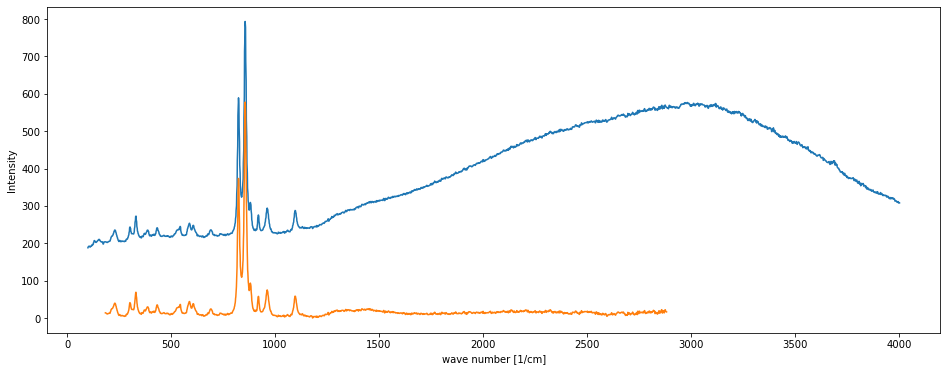

In [14]:
raman_plot()
plt.plot(data.wn,data.r1c2)
plt.plot(data_bkg.wn,data_bkg.r1c2);

### Rimozione dell'offset
Come abbiamo visto dagli spettri puri nessuno spettro presentava un offset rilevante, diversamente dagli spettri incogniti. Per eliminare/ridurre questo offset utilizziamo il fatto che tutti gli spettri puri hanno una coda che va a zero. Imponiamo dunque questo anche agli spettri incogniti, calcolando l'offset sulla coda e sottraendolo a tutto lo spettro. Di seguito un **esempio**.

In [15]:
wn_soglia=1250 #da dove inizia la coda
for i in enumerate(data_bkg.wn):
    if wn_soglia==i[1]:
        element_soglia=i[0] #è l'elemento di soglia, legato al numero d'onda di soglia

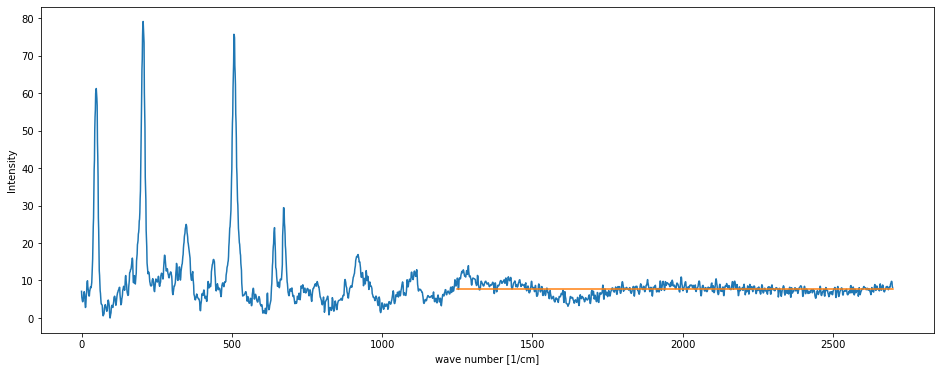

In [16]:
raman_plot()
sample='r4c7' #il sample su cui faccio gli esempi
data_bkg[sample].plot()
offset=data_bkg[sample][element_soglia::].mean()

plt.plot([wn_soglia,2700],[offset,offset]);

Implementiamo poi il procedimento su tutti i sample

In [17]:
for temp in names[1::]:
    offset=data_bkg[temp][element_soglia::].mean()
    data_bkg[temp]=data_bkg[temp]-offset

Di seguito il risultato.

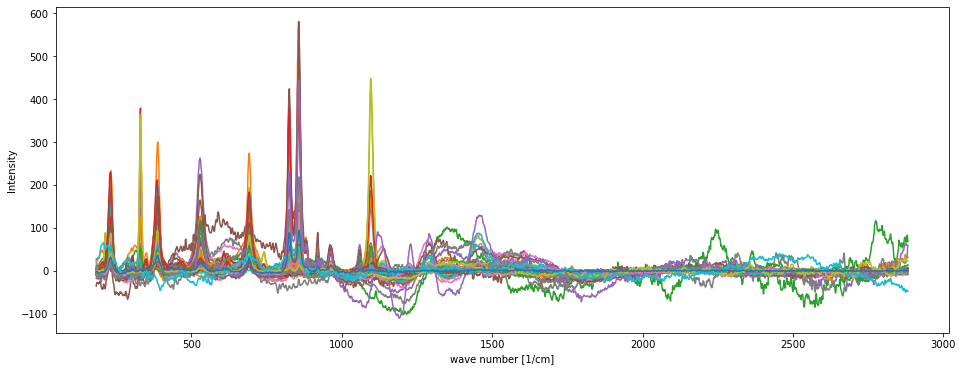

In [18]:
raman_plot()
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp])

### Normalizzazione degli spettri sperimentali
Anche quì gli spettri non sono normalizzati tra di loro, per confrontarli prima di tutto li normalizziamo.

In [19]:
for i in names[1:]:
    data_bkg[i]=data_bkg[i]/np.trapz(abs(data_bkg[i][:element_soglia]), x=data_bkg['wn'][0:element_soglia])

Di seguito il risultato: **tutti gli spettri sperimentali normalizzati senza background**.

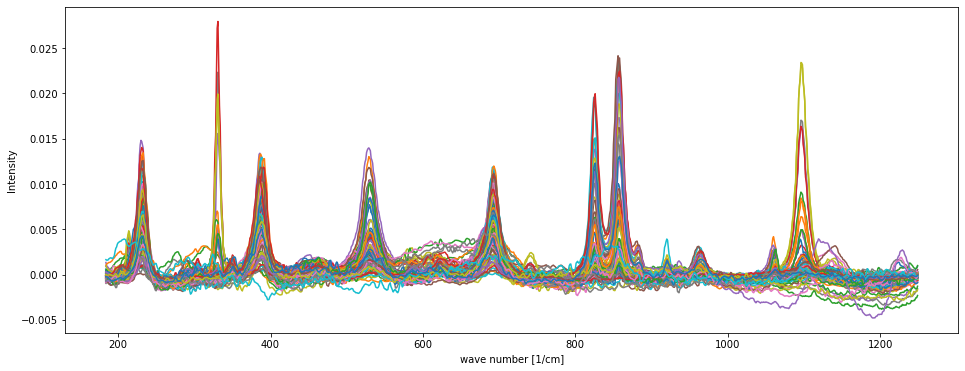

In [20]:
raman_plot()
for temp in names[1:]:
    plt.plot(data_bkg.wn[:element_soglia],data_bkg[temp][:element_soglia])

### Salvataggio dei dati senza rimozione del rumore
Di seguito salviamo i dati normalizzati ed a offset rimosso, ci possono tornare utili in futuro.

In [21]:
data_bkg[0:element_soglia].to_csv("../data/processed/data_normalized_without_offset.csv")

### Tentativo di rimuovere il rumore ad alta frequenza mediando punti vicini (non utilizzato)
Tentiamo quì di rumuovere il rumore mediando punti con numero d'onda vicino. Tuttaviam capiamo subito che il rumore che presentano gli spettri è a frequenze molto più basse e dunque con questo metodo non viene attenuato dato che non possiamo mediare con troppi punti, altrimenti abbassiamo i picchi. L'unica applicazione che potrebbe avere è che, come si vede dal grafico sottostante, possiamo mediare su due punti e la curva non viene modificata sensibilmente. Questo porterebbe il vantaggio di lavorare con spettri aventi la metà dei punti.

In [22]:
sample='r7c7' #scelgo su cosa guardare questa cosa
N=2 #numero di medie (binning)
x=[]
y=[]
for i in range(int(len(data_bkg[sample])/N)):
    y.append(data_bkg[sample][N*i:N*i+N].mean())   
for i in range(int(len(data_bkg.wn)/N)):
    x.append(data_bkg.wn[N*i:N*i+N].mean())   

Tentativo di rimuovere il rumore


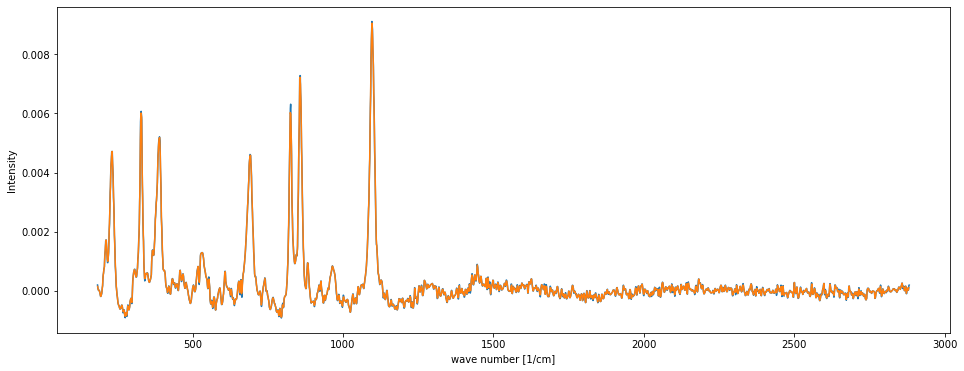

In [23]:
raman_plot()
plt.plot(data_bkg.wn,data_bkg[sample])
plt.plot(x,y)
print("Tentativo di rimuovere il rumore")

### Mettiamo una soglia al rumore in base alla varianza calcolata sulla coda dello spettro

Temiamo che gli algoritmi di clusterizzatione e di regressione possano "imparare" dal rumore di fondo. Questo potrebbe contenere informazione come non conterle, ma dato che siamo interessati a riconoscere le abbondanze principali dei materiali del nostro campione possiamo trascurarlo. Per ridurre questo rumore dagli spettri sperimentali procediamo come segue.
Ipotizziamo che il rumore non dipenda dal numero d'onda e calcolando la varianza sulla coda dei grafici (che per confronto con gli spettri puri dovrebbe essere a zero) fissiamo una soglia (in funzione della varianza) all'intensità su tutta la curva. I punti con intensità inferiore alla soglia (fissata a $3\sigma$) sono messi a zero.

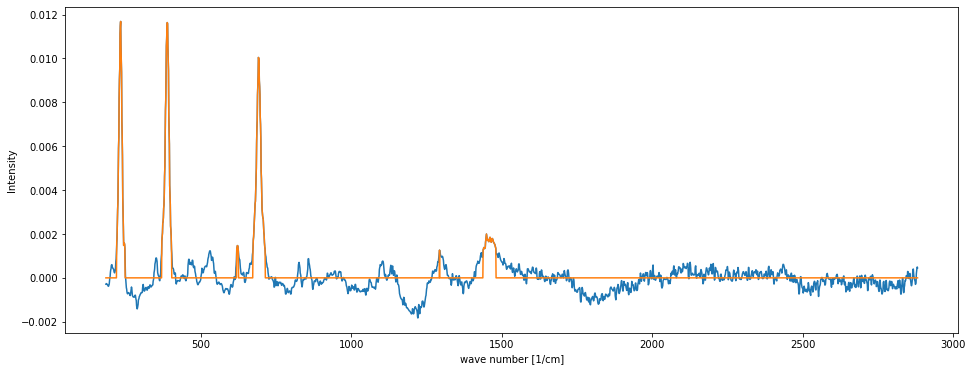

In [24]:
sample='r7c6' #il sample su cui faccio gli esempi
sigma=data_bkg[sample][element_soglia:].std() #calcolo la std
bound=2.5*sigma #fisso il bound del rumore a 3 volte il sigma della coda
y=data_bkg[sample].copy()
x=data_bkg.wn
for i in enumerate(y):
    if i[1]<bound:
        y[i[0]]=0

raman_plot()
plt.plot(data_bkg.wn,data_bkg[sample])
plt.plot(x,y);

Poi lo faccio poi per tutti gli spettri, devo scegliere quanti sigma usare come bound.

In [25]:
n_sigma=2.5
for temp in names[1:]:
    bound=n_sigma*data_bkg[temp][element_soglia:].std() #calcolo la std sulla coda
    for i in enumerate(data_bkg[temp]):
        if i[1]<bound:
            data_bkg[temp][i[0]]=0

Questo è il risultato.

<function title at 0x7fe52e07d5e0>


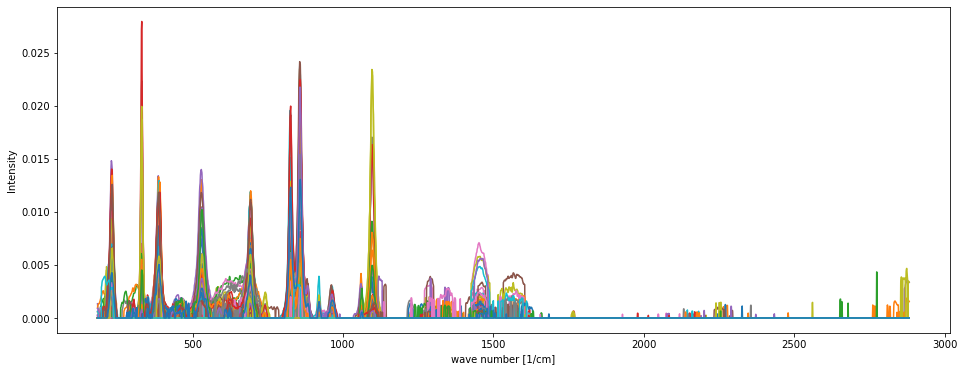

In [26]:
raman_plot()
print(plt.title)
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp])

###  Eliminazione della coda

In [27]:
# qui elimino la coda
data_bkg = data_bkg[0:element_soglia]

In [28]:
# qui rinormalizzo
#for i in names[1::]:
#    data_bkg[i]=data_bkg[i]/np.trapz((data_bkg[i]), x=data_bkg.wn)

Adesso gli spettri hanno questa forma

<function title at 0x7fe52e07d5e0>


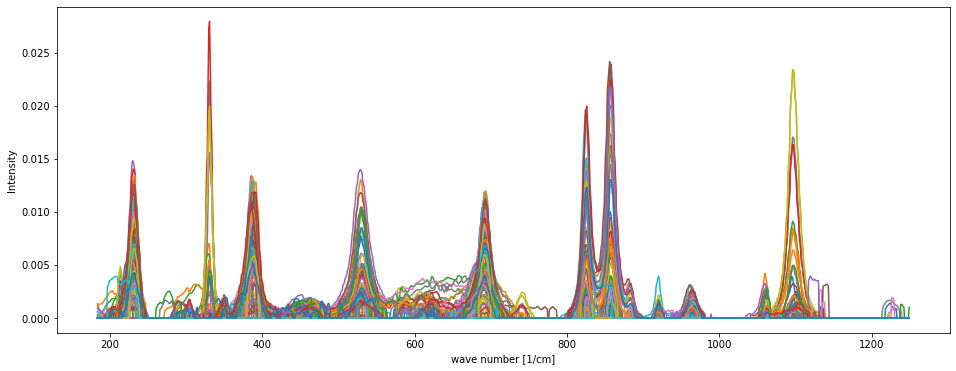

In [29]:
raman_plot()
print(plt.title)
for temp in names[1:]:
    plt.plot(data_bkg.wn,data_bkg[temp])

### Salvataggio dei dati con rumore rimosso

In [30]:
data_bkg.to_csv("../data/processed/EDA_processed_data.csv")